# Predict Lift Ticket Price

## First model: Linear Regression

In [37]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import warnings
import folium
import branca
from folium.plugins import MarkerCluster
import math
# current_palette = sns.color_palette("Paired")
sns.set_palette(sns.color_palette("Set1"))
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
sns.set_context(rc={"lines.linewidth": 2.5})

lr = LinearRegression()

RSEED = 100

isFigure = False # turn off unnecessary figures

### Bin the Data by Lift Cost
We need to first bin the data by lift rate

In [14]:
data = pd.read_csv('SkiResort_Combined_test.csv')
# data.describe()
data['fare-bin'] = pd.cut(data['adult day pass'], bins = list(range(10, 200, 10))).astype(str)

# Visualize the bins
# Uppermost bin
data.loc[data['fare-bin'] == 'nan', 'fare-bin'] = '[190+]'

# # Adjust bin so the sorting is correct
# data.loc[data['fare-bin'] == '(0, 10]', 'fare-bin'] = '(000, 010]'
data.loc[data['fare-bin'] == '(10, 20]', 'fare-bin'] = '(010, 020]'
data.loc[data['fare-bin'] == '(20, 30]', 'fare-bin'] = '(020, 030]'
data.loc[data['fare-bin'] == '(30, 40]', 'fare-bin'] = '(030, 040]'
data.loc[data['fare-bin'] == '(40, 50]', 'fare-bin'] = '(040, 050]'
data.loc[data['fare-bin'] == '(50, 60]', 'fare-bin'] = '(050, 060]'
data.loc[data['fare-bin'] == '(60, 70]', 'fare-bin'] = '(060, 070]'
data.loc[data['fare-bin'] == '(70, 80]', 'fare-bin'] = '(070, 080]'
data.loc[data['fare-bin'] == '(80, 90]', 'fare-bin'] = '(080, 090]'
data.loc[data['fare-bin'] == '(90, 100]', 'fare-bin'] = '(090, 100]'


# Bar plot of value counts
if isFigure:
    data['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');
    plt.title('Fare Binned');

### Get rid of bins without enough data

In [15]:
data = data.dropna(subset=['drop (m)','AVG_GOODDAYS','runCount_x'])
count = data['fare-bin'].value_counts()
bad = list(count[data['fare-bin'].value_counts() < 3].index)
for ii in bad:
    data = data[data['fare-bin'] != ii]

if isFigure:    
    data['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');
    sns.catplot(x="runCount_x", y="fare-bin", kind="box", data=data);


### Scale features

In [16]:
# scale the vertical drop by 10 so that is closer to the values of the other features
data['drop (m)'] = data['drop (m)']/10

## Create the training and validation sets

In [17]:
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['adult day pass']), 
                                                      stratify = data['fare-bin'],
                                                      random_state = RSEED, test_size = 0.5)

Choose and train the features

In [18]:
# set the features
features = ['lat_x', 'drop (m)', 'AVG_GOODDAYS','runCount_x']

In [20]:
lr.fit(X_train[features], y_train)

print('Intercept', round(lr.intercept_, 4))
print('lat_x coef: ', round(lr.coef_[0], 4), 
      '\tdrop coef:', round(lr.coef_[1], 4),
      '\tAVG_GOODDAYS coef:', round(lr.coef_[2], 4))

Intercept 185.1791
lat_x coef:  -3.3691 	drop coef: 0.3268 	AVG_GOODDAYS coef: -0.0268


#### Use function to score the model
* __Root mean squared error__: the metric used by the competition
* __Mean absolute percentage error__: the average percentage error of the predictions

In [21]:
warnings.filterwarnings('ignore', category = RuntimeWarning)

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')

In [22]:
evaluate(lr, features, 
        X_train, X_valid, y_train, y_valid)

Training:   rmse = 18.0 	 mape = 22.29
Validation: rmse = 23.31 	 mape = 27.45


### Calculate Baseline

Compare these predictions to a naive guess. For now use the average value of the target in the training data.

In [23]:
train_mean = y_train.mean()

# Create list of the same prediction for every observation
train_preds = [train_mean for _ in range(len(y_train))]
valid_preds = [train_mean for _ in range(len(y_valid))]

tr, vr, tm, vm = metrics(train_preds, valid_preds, y_train, y_valid)

print(f'Baseline Training:   rmse = {round(tr, 2)} \t mape = {round(tm, 2)}')
print(f'Baseline Validation: rmse = {round(vr, 2)} \t mape = {round(vm, 2)}')

Baseline Training:   rmse = 34.89 	 mape = 47.86
Baseline Validation: rmse = 36.83 	 mape = 50.1


### Try with more Features

In [24]:
lr.fit(X_train[features], y_train)
# print('Intercept', round(lr.intercept_, 4))
# print('long_x coef: ', round(lr.coef_[0], 4), 
#       '\tlong_x coef:', round(lr.coef_[1], 4),
#       '\tAVG_COLDDAYS coef:', round(lr.coef_[2], 4),
#      '\trunCount coef:', round(lr.coef_[3], 4))
evaluate(lr, features, 
         X_train, X_valid, y_train, y_valid)

Training:   rmse = 18.0 	 mape = 22.29
Validation: rmse = 23.31 	 mape = 27.45


In [25]:
# Get rid of yearly temp data
cold_cols = [col for col in data.columns if '_COLD' in col]
# for ii in cold_cols:
#     data = data.drop(ii)
data = data.drop(columns=cold_cols)
hot_cols = [col for col in data.columns if '_HOT' in col]
data = data.drop(columns=hot_cols)

bad_cols = [col for col in data.columns if '_y' in col]
data = data.drop(columns=bad_cols)

In [26]:
if isFigure:
    corrdata = data[['lat_x','long_x','runCount_x','liftCount_x','skiableAcreage_x','longestRun_x','adult day pass','drop (m)','AVG_GOODDAYS']]
    corrs = corrdata.corr()

    plt.figure(figsize = (12, 12))
    sns.heatmap(corrs, annot = True, vmin = -1, vmax = 1, fmt = '.3f', cmap=plt.cm.PiYG_r);

## Implement Random Forest Model

In [27]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest
random_forest = RandomForestRegressor(n_estimators = 20, max_depth = 20, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

# Train on data
random_forest.fit(X_train[features], y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)

In [28]:
evaluate(random_forest, features,
         X_train, X_valid, y_train, y_valid)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.0s finished


Training:   rmse = 7.49 	 mape = 8.52
Validation: rmse = 23.11 	 mape = 24.99


Good news is that our training error dropped a ton but the bad news is that hte validation error stayed the same.

In this instance I think the issue is that we don't have enough data ... 

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.0s finished


(0, 200)

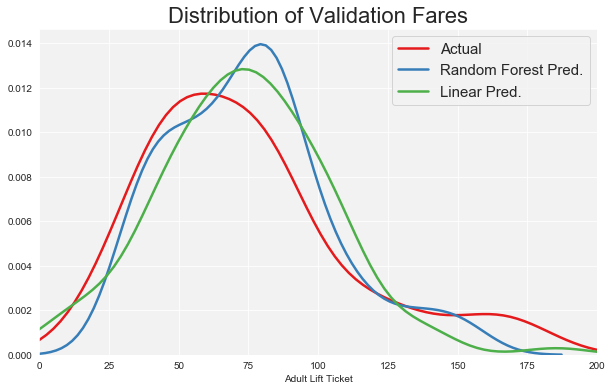

In [30]:
valid_preds = random_forest.predict(X_valid[features])
valid_lr = lr.predict(X_valid[features])
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
# sns.set()

plt.figure(figsize = (10, 6))
ax=sns.kdeplot(y_valid, label = 'Actual')
sns.kdeplot(valid_preds, label = 'Random Forest Pred.')
sns.kdeplot(valid_lr, label = 'Linear Pred.')
plt.legend(prop = {'size': 15})
plt.title("Distribution of Validation Fares",size=22);
plt.xlabel('Adult Lift Ticket')
plt.xlim([0,200])

**Preliminary Results:**

We see that while the random forest model has helped to fit out test data, it has not improved the fit to the validation data compared to hte linear model.  I believe this a result of overfitting from the random forest model and can be significantly improved by the addition of data and hyper parameter tuning.

## Map the results
We will map the locations of ski resort and color them by misfit to the model to show where we see the most and least improvement

In [43]:
def fancy_html(row):
    
    Region = row['region']
    Name=row['name']
    NRuns=row['runCount_x']
    Vert = row['drop (m)']
    Good = row['AVG_GOODDAYS']
    Fare = str(int(row['adult day pass']))
    Est = str(int(row['Calc Fare']))
    if math.isnan(NRuns):
        NRuns = 'Unknown'
    else:
        NRuns = str(int(NRuns))
        
    if math.isnan(Vert):
        Vert = 'Unknown'
    else:
        Vert = str(float(Vert))
    
    if math.isnan(Good):
        Good = 'Unknown'
    else:
        Good = str(int(Good))
        
#     Number_of_Casualties = row['Number_of_Casualties'].iloc[i]                           
#     Date = row['created_x']
#     Time = row['NYEAR']                                    
#     Light_Conditions = df['Light_Conditions'].iloc[i]                               
#     Weather_Conditions = df['Weather_Conditions'].iloc[i]      
#     Road_Surface_Conditions = df['Road_Surface_Conditions'].iloc[i]
    
    left_col_colour = "#2A799C"
    right_col_colour = "#C5DCE7"
    
    html = """<!DOCTYPE html>
<html>

<head>
<h4 style="margin-bottom:0"; width="200px">{}{}</h4>""".format(Name,"<br>" + Region) + """

</head>
    <table style="height: 120px; width: 300px;">
<tbody>
<tr>
<td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;">No. Runs</span></td>
<td style="width: 200px;background-color: """+ right_col_colour +""";">{}</td>""".format(NRuns) + """
</tr>
<tr>
<td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;">Vertical Drop (m)</span></td>
<td style="width: 200px;background-color: """+ right_col_colour +""";">{}</td>""".format(Vert) + """
</tr>
<tr>
<td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;">No. Freezing Days</span></td>
<td style="width: 200px;background-color: """+ right_col_colour +""";">{}</td>""".format(Good) + """
</tr>
<tr>
<td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;">Lift Ticket Price</span></td>
<td style="width: 200px;background-color: """+ right_col_colour +""";">{}</td>""".format(Fare) + """
</tr>
<tr>
<td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;">Pred. Lift Ticket Price</span></td>
<td style="width: 200px;background-color: """+ right_col_colour +""";">{}</td>""".format(Est) + """
</tr>
</tbody>
</table>
</html>
"""
    return html

In [44]:
# estimate the lift ticket prices for the entire dataset
total_preds = random_forest.predict(data[features])

data['Calc Fare'] = total_preds
data['Fare Diff'] = (data['adult day pass'] - data['Calc Fare'])/data['adult day pass']*100

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.0s finished


In [57]:


m = folium.Map(location=[42,-92], zoom_start = 4.2, tiles = "cartodbpositron")
cluster = MarkerCluster().add_to(m)

for index, row in data.iterrows():
    html = fancy_html(row)
     
    if row['Fare Diff'] < 20:
        colr = 'green'
    elif 20 <= row['Fare Diff'] < 50:
        colr = 'orange'
    else:
        colr = 'red'

    iframe = branca.element.IFrame(html=html,width=400,height=250)
    popup = folium.Popup(iframe,parse_html=True)
    folium.CircleMarker(location=[row['lat_x'], row['long_x']], radius = 9, popup=popup, fill_color=colr, color="gray", fill_opacity = 0.9).add_to(cluster)

m.save('SkiResort_Map.html')
m

**Results**


The above map will likely not render on GitHub so please click [here](https://www.ldeo.columbia.edu/~accardo/TDI/SkiResort_map.html) to see the interactive map of prediction results.